In [42]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

In [43]:
# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [44]:
# ticker and the start and end dates for testing
ticker =  '^NSEI' # Nifty 50 benchmark
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 7, 31)

In [45]:
# download ticker 'Adj Close' price from yahoo finance
stock = yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,^NSEI
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902


In [46]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,^NSEI,returns,direction
Date,,,
2010-01-05,5277.899902,0.008696,1
2010-01-06,5281.799805,0.000739,1
2010-01-07,5263.100098,-0.003547,-1


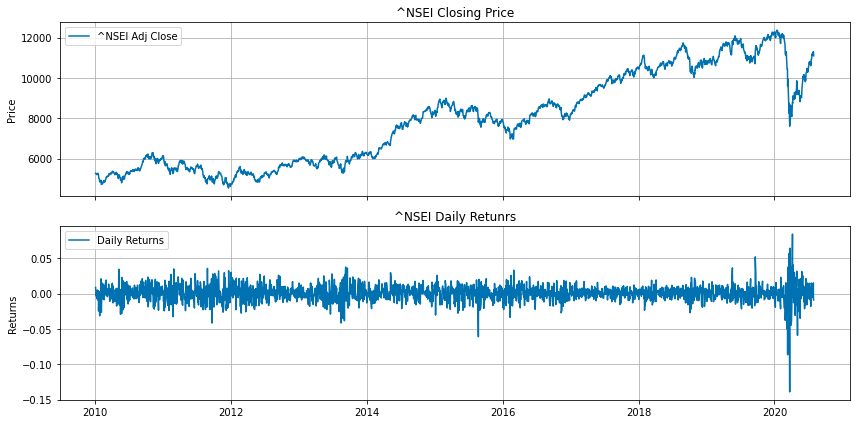

In [47]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
# plt.savefig('images/chart1', dpi=300)

In [48]:
# define the number of lags
lags = [1, 2, 3, 4, 5]
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock

,^NSEI,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2010-01-12,5210.399902,-0.007457,-1,0.000886,-0.003493,-0.003547,0.000739,0.008696
2010-01-13,5233.950195,0.004510,1,-0.007457,0.000886,-0.003493,-0.003547,0.000739
2010-01-14,5259.899902,0.004946,1,0.004510,-0.007457,0.000886,-0.003493,-0.003547
2010-01-15,5252.200195,-0.001465,-1,0.004946,0.004510,-0.007457,0.000886,-0.003493
2010-01-18,5274.850098,0.004303,1,-0.001465,0.004946,0.004510,-0.007457,0.000886
...,...,...,...,...,...,...,...,...
2020-07-24,11194.150391,-0.001901,-1,0.007415,-0.002660,0.012626,0.010993,0.014948
2020-07-27,11131.799805,-0.005585,-1,-0.001901,0.007415,-0.002660,0.012626,0.010993
2020-07-28,11300.549805,0.015046,1,-0.005585,-0.001901,0.007415,-0.002660,0.012626


In [49]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

create_bins(stock)
stock

,^NSEI,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,,,,
2010-01-12,5210.399902,-0.007457,-1,0.000886,-0.003493,-0.003547,0.000739,0.008696,1,0,0,1,1
2010-01-13,5233.950195,0.004510,1,-0.007457,0.000886,-0.003493,-0.003547,0.000739,0,1,0,0,1
2010-01-14,5259.899902,0.004946,1,0.004510,-0.007457,0.000886,-0.003493,-0.003547,1,0,1,0,0
2010-01-15,5252.200195,-0.001465,-1,0.004946,0.004510,-0.007457,0.000886,-0.003493,1,1,0,1,0
2010-01-18,5274.850098,0.004303,1,-0.001465,0.004946,0.004510,-0.007457,0.000886,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-24,11194.150391,-0.001901,-1,0.007415,-0.002660,0.012626,0.010993,0.014948,1,0,1,1,1
2020-07-27,11131.799805,-0.005585,-1,-0.001901,0.007415,-0.002660,0.012626,0.010993,0,1,0,1,1
2020-07-28,11300.549805,0.015046,1,-0.005585,-0.001901,0.007415,-0.002660,0.012626,0,0,1,0,1


In [50]:
# create a dictionary of selected algorithms
models = {
 'log_reg': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP' : MLPClassifier(max_iter=500),
}

In [51]:
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}

In [52]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

/bin/bash: asd: command not found
